Requires notebook 2.

In [66]:
suppressPackageStartupMessages({
  library(cellAdmix)
  library(cowplot)
  library(dataorganizer)
  library(dplyr)
  library(ggrepel)
  library(ggplot2)
  library(ggrastr)
  library(latex2exp)
  library(magrittr)
  library(Matrix)
  library(readr)
  library(sccore)
  library(Seurat)
  library(sparseMatrixStats)
  library(viridis)
})

devtools::load_all()

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks
Warning message:
“Objects listed as exports, but not present in namespace:
• plot_expression_comparison”


## Load data

### Seurat

In [2]:
so_rna <- DatasetPath('human_ovarian_cancer_rna', 'processed', 'so.rds') %>% readRDS()
so_rna

An object of class Seurat 
18082 features across 15372 samples within 1 assay 
Active assay: RNA (18082 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [3]:
so_spatial <- DatasetPath("human_ovarian_cancer", "processed", 'so.rds') %>%
    readRDS()

so_spatial

An object of class Seurat 
5101 features across 373830 samples within 1 assay 
Active assay: RNA (5101 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: spatial, pca, umap

In [4]:
so_spatial$cell_type <- so_spatial$cell_type_full
so_rna$cell_type <- so_rna$cell_type_full

In [5]:
common_genes <- intersect(rownames(so_rna), rownames(so_spatial))
length(common_genes)

[1] 4912

In [6]:
cat('Spatial:')
setdiff(so_spatial$cell_type, so_rna$cell_type)
cat('scRNA-seq:')
setdiff(so_rna$cell_type, so_spatial$cell_type)

Spatial:

[1] "SOX2-OT+ Tumor Cells"

scRNA-seq:

[1] "MT-High, Jun+/Fos+ Tumor Cells"

In [7]:
so_spatial %<>% subset(features=common_genes)
so_rna %<>% subset(features=common_genes)
so_spatial %<>% subset(cells=colnames(.)[.$cell_type %in% unique(so_rna$cell_type)])

In [8]:
sos <- list(spatial=so_spatial, scRNAseq=so_rna)

### Molecules

In [9]:
df_spatial <- DatasetPath('human_ovarian_cancer', 'transcripts.parquet') %>%
    arrow::read_parquet() %>% as_tibble() %>%
    rename(x=x_location, y=y_location, z=z_location, gene=feature_name) %>%
    mutate(cell=as.character(cell_id), cell_type=so_spatial$cell_type[cell]) %>%
    filter(!is.na(cell_type))

nrow(df_spatial)

[1] 128195647

### Estimate adjacency

In [10]:
cell_adj_df <- estimate_cell_adjacency(df_spatial, random.shift=1e-2, n.cores=70)
cell_type_adj_mat <- estimate_cell_type_adjacency(cell_adj_df)
cell_type_adj_mat

,Ciliated Epithelial Cells,Endothelial Cells,Fallopian Tube Epithelium,Granulosa Cells,Inflammatory Tumor Cells,Macrophages,Malignant Cells Lining Cyst,Pericytes,Proliferative Tumor Cells,Smooth Muscle Cells,Stromal Associated Fibroblasts,T & NK Cells,Tumor Associated Fibroblasts,Tumor Cells,VEGFA+ Tumor Cells
Ciliated Epithelial Cells,1.610136,1.117647,1.327869,1.000000,1.090909,1.170732,1.000000,1.052632,1.116938,1.076923,1.162791,1.129032,1.100457,1.163654,1.031915
Endothelial Cells,1.000000,1.519614,1.022727,1.047619,1.187500,1.224100,1.185185,1.535482,1.124528,1.281411,1.149007,1.214173,1.193864,1.097122,1.000000
Fallopian Tube Epithelium,1.542857,1.451613,1.923167,1.178218,1.100000,1.591241,1.047619,0.000000,1.106383,1.369048,1.353659,1.644737,1.203390,1.366176,1.000000
Granulosa Cells,1.000000,1.375000,1.950820,3.363439,1.000000,2.396552,1.222222,1.000000,1.000000,1.714286,1.484375,2.346154,1.456522,1.964286,2.000000
Inflammatory Tumor Cells,1.333333,2.375000,1.571429,3.000000,3.591166,1.931741,1.222222,2.000000,1.577899,0.000000,0.000000,1.577778,1.552239,1.578664,1.320000
Macrophages,1.158621,1.166667,1.058252,1.065134,1.238512,1.529412,1.330042,1.192195,1.185207,1.089122,1.100252,1.276578,1.249497,1.197275,1.270013
Malignant Cells Lining Cyst,1.500000,1.560976,1.375000,1.540000,1.375000,1.543372,2.269314,1.421053,1.378378,1.214286,1.512195,1.588477,1.603636,1.291071,1.166667
Pericytes,1.052632,1.730098,0.000000,1.000000,1.000000,1.239351,1.125000,1.885036,1.075581,1.440585,1.253333,1.143541,1.290275,1.074488,1.000000
Proliferative Tumor Cells,1.919610,1.290043,1.106383,1.166667,1.586521,1.817665,1.356383,1.370370,2.774345,1.380952,1.000000,1.490602,1.382404,1.876412,1.570141
Smooth Muscle Cells,1.076923,1.211554,1.045455,1.043478,0.000000,1.102122,1.000000,1.268921,1.000000,1.652122,1.245907,1.109920,1.108796,1.042735,1.000000


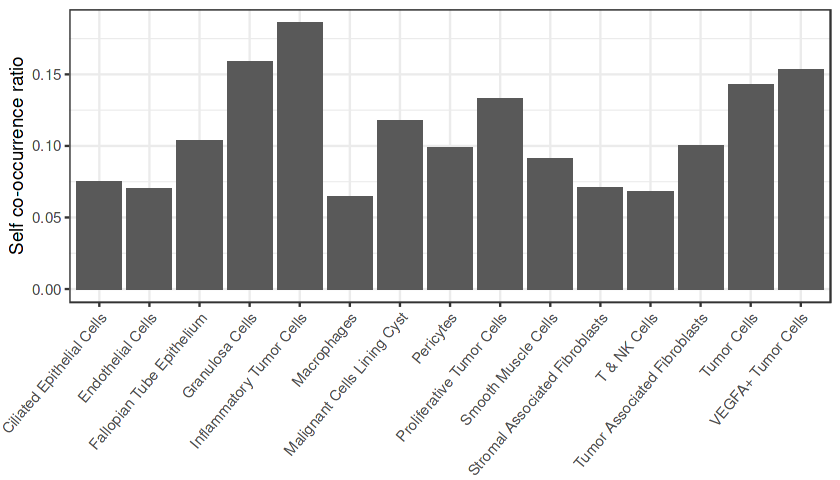

In [123]:
options(repr.plot.width=7, repr.plot.height=4)

diag_ratio <- (diag(cell_type_adj_mat) / colSums(cell_type_adj_mat)) %>%
  {tibble(ratio=., cell_type=names(.))}

ggplot(diag_ratio) +
  geom_col(aes(x=cell_type, y=ratio)) +
  theme(axis.text.x=element_text(angle=50, vjust=1, hjust=1)) +
  ylab('Self co-occurrence ratio') +
  theme(axis.title.x=element_blank())

## Overview

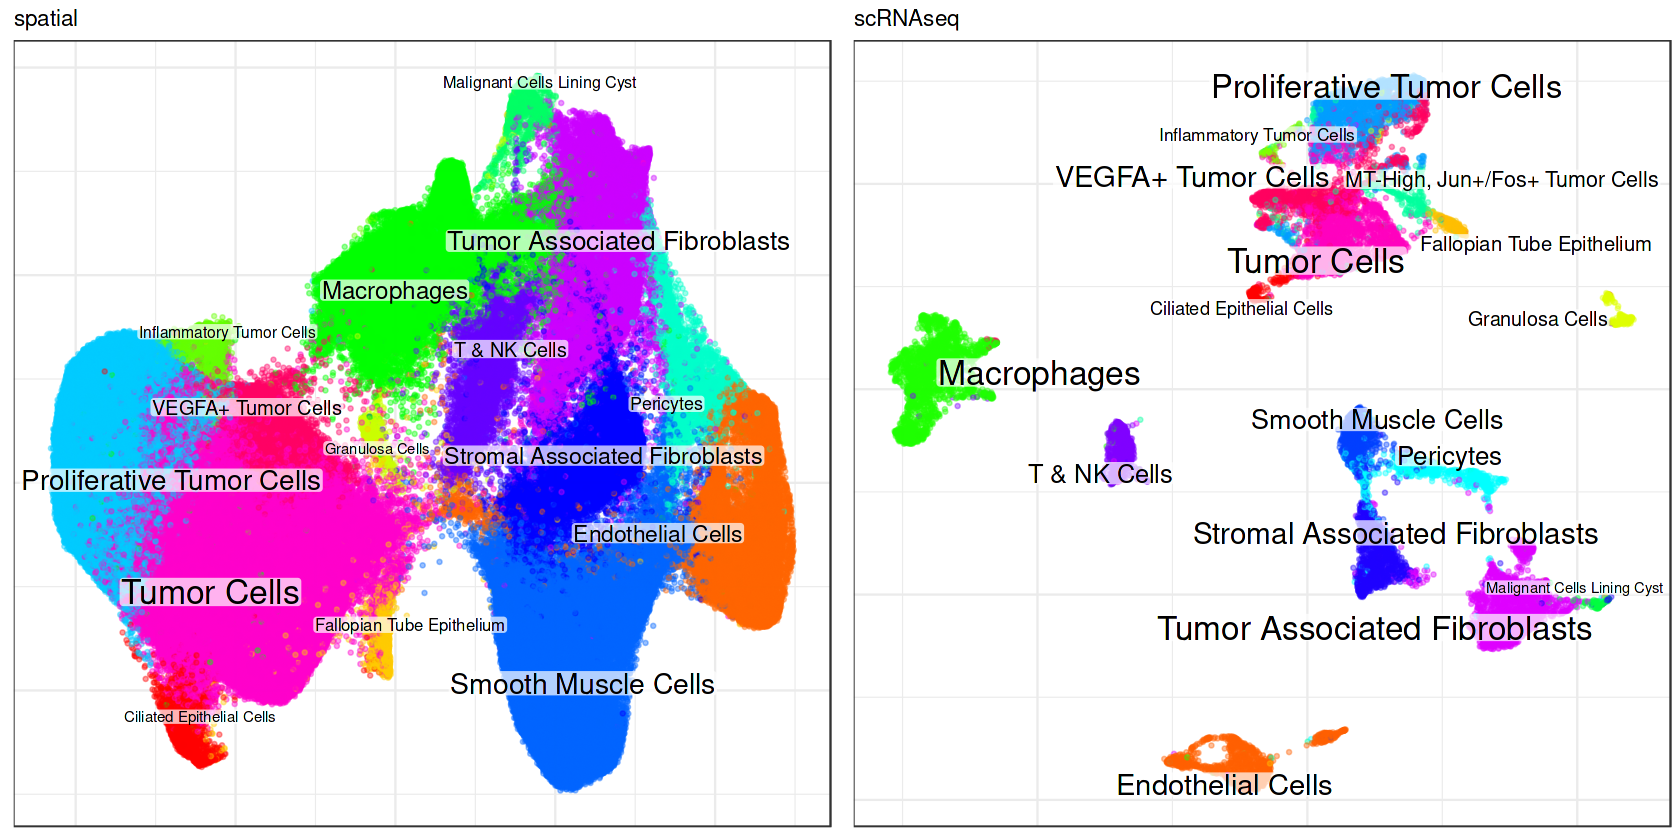

In [11]:
options(repr.plot.width=14, repr.plot.height=7)
lapply(names(sos), \(n) {
    embeddingPlot(sos[[n]], groups='cell_type', reduction='umap', title=n)
}) %>% cowplot::plot_grid(plotlist=., ncol=2)

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_bar()`).”


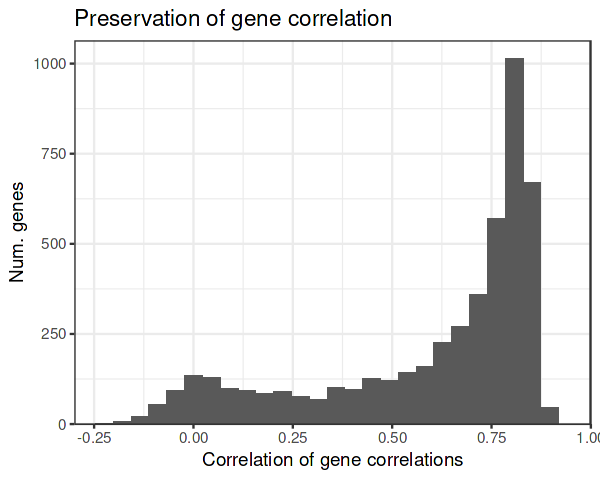

In [13]:
options(repr.plot.width=5, repr.plot.height=4)

cor_cors <- estimate_correlation_preservation(so_spatial[['RNA']]$data, so_rna[['RNA']]$data)
gg_cors <- plot_correlation_preservation(cor_cors) +
  scale_x_continuous(limits=c(-0.3, 1.0), expand=c(0, 0))
gg_cors

## Estimate doublet scores

In [14]:
signal_thres <- 0.6
exclude_genes <- names(cor_cors)[cor_cors < 0.5]
length(exclude_genes)

[1] 1355

In [15]:
cont_info <- estimate_contamination_scores_seurat(
  so_rna, so_spatial, cell.type.adj.mat=cell_type_adj_mat,
  p.c=0.25, signal.thres=signal_thres, min.expr.frac=0.05,
  exclude.genes=exclude_genes
)

In [16]:
cont_info_rna <- estimate_contamination_scores_seurat(
  so_rna, so_rna, cell.type.adj.mat=cell_type_adj_mat,
  p.c=0.25, signal.thres=signal_thres, min.expr.frac=0.05,
  exclude.genes=exclude_genes
)

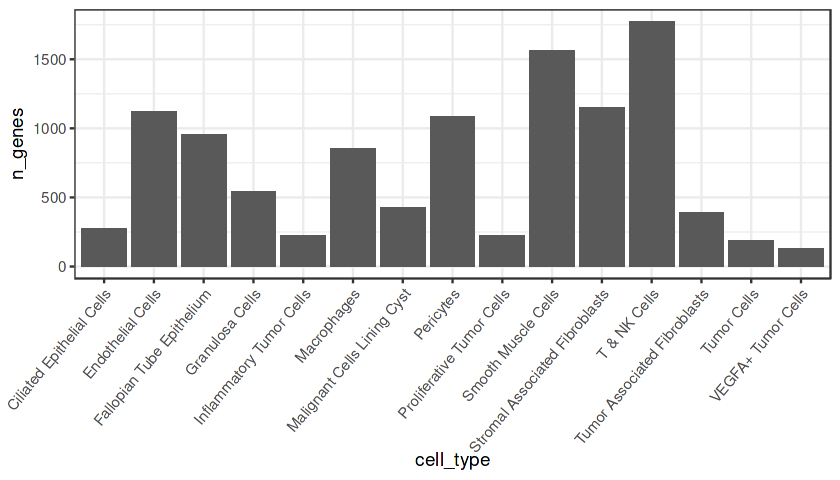

In [119]:
options(repr.plot.width=7, repr.plot.height=4)

n_informative_genes <- colSums(cont_info$cont.probs.per.type > 0) %>%
  {tibble(n_genes=., cell_type=names(.))}

ggplot(n_informative_genes) +
  geom_col(aes(x=cell_type, y=n_genes)) +
  theme(axis.text.x=element_text(angle=50, vjust=1, hjust=1))

### Distributions

In [39]:
doublet_df <- cont_info$doublet.scores %>%
  {data.frame(scores=., cell_type=so_spatial$cell_type[names(.)], cell=names(.), dataset='spatial')}

doublet_df_rna <- cont_info_rna$doublet.scores %>%
  {data.frame(scores=., cell_type=so_rna$cell_type[names(.)], cell=names(.), dataset='scRNA-seq')}

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?


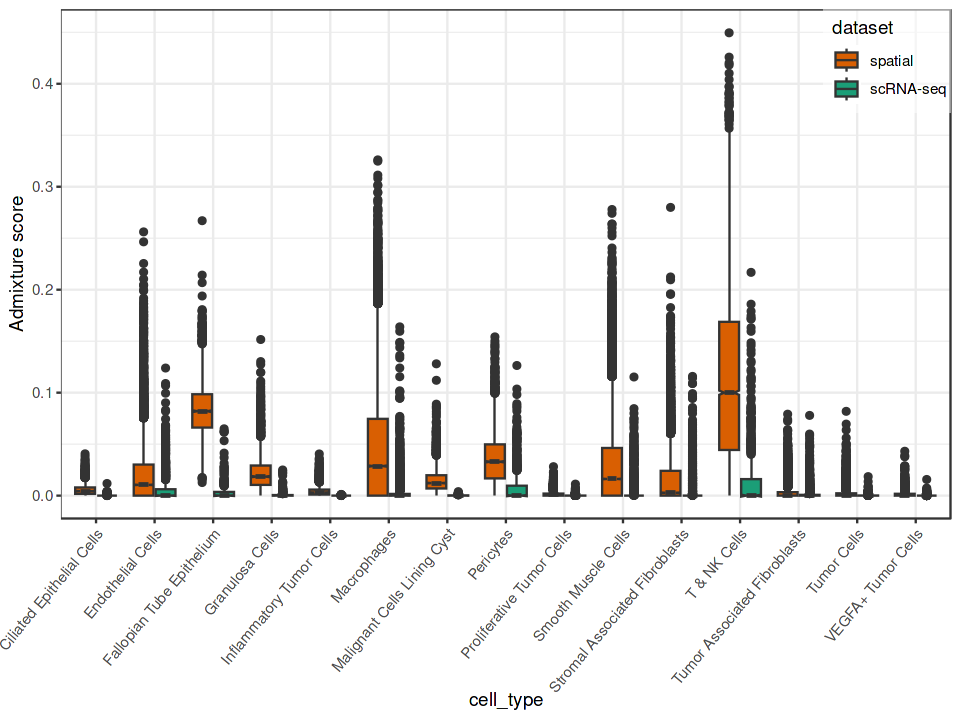

In [48]:
options(repr.plot.width=8, repr.plot.height=6)

p_df <- rbind(doublet_df, doublet_df_rna) %>%
  mutate(dataset=factor(dataset, levels=c('spatial', 'scRNA-seq')))

gg_scores <- ggplot(p_df) +
  geom_boxplot(aes(x=cell_type, y=scores, fill=dataset), notch=TRUE) +
  ylim(0.0, 0.45) +
  ylab('Admixture score') + theme_legend(position=c(1, 1)) +
  scale_fill_manual(values=c('#d95f02', '#1b9e77')) +
  theme(axis.text.x=element_text(angle=50, vjust=1, hjust=1))

gg_scores

### Plot doublet scores

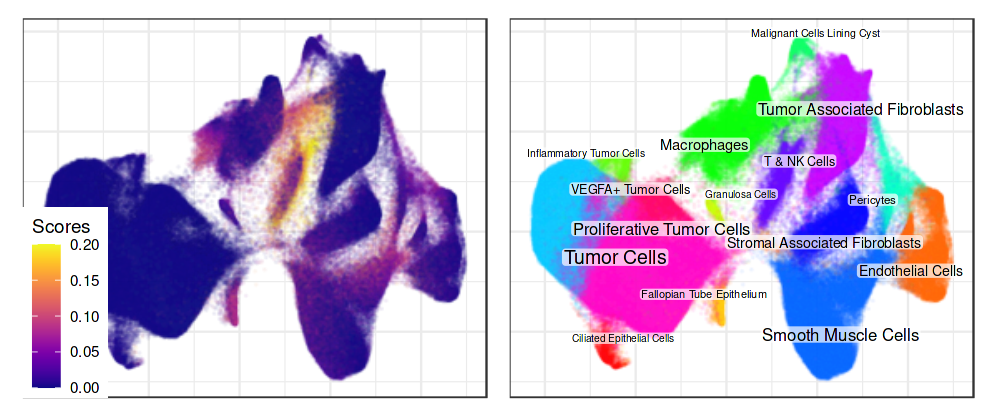

In [148]:
options(repr.plot.width=8.268, repr.plot.height=3.5)
gg_score_umap <- embeddingPlot(
  so_spatial, reduction='umap',
  colors=pmin(cont_info$doublet.scores, 0.2),
  show.legend=TRUE, legend.position=c(0, 0), legend.title='Scores',
  plot.na=-1, size=0.01, alpha=0.05, palette=viridis::plasma
)
gg_cell_type_umap <- embeddingPlot(
  so_spatial, reduction='umap',
  groups='cell_type', mark.groups=TRUE, size=0.01, alpha=0.05, font.size=c(2, 4)
)
rasterise(gg_score_umap) | rasterise(gg_cell_type_umap)

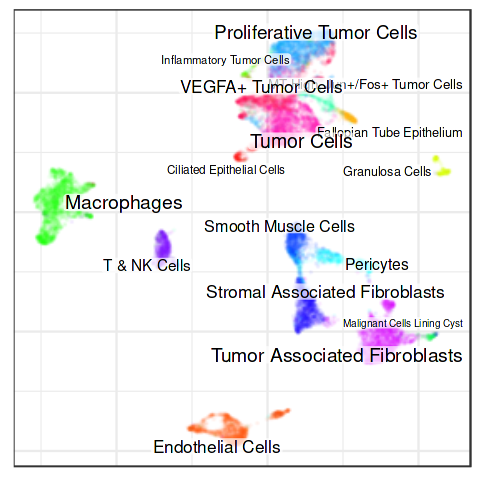

In [147]:
options(repr.plot.width=4, repr.plot.height=4)
gg_cell_type_umap_rna <- embeddingPlot(
  so_rna, reduction='umap',
  groups='cell_type', mark.groups=TRUE, size=0.01, alpha=0.05, font.size=c(2, 4)
)
rasterize(gg_cell_type_umap)

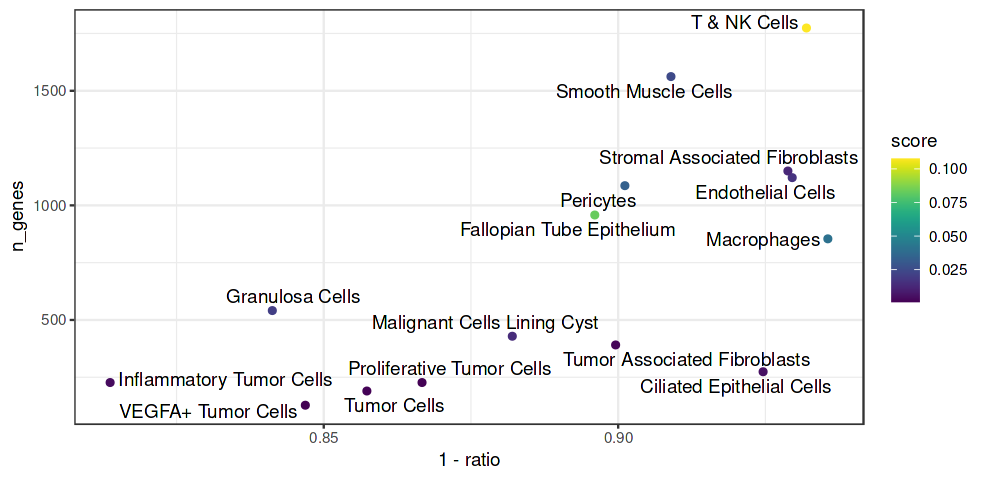

In [172]:
p_df <- doublet_df %>%
  group_by(cell_type) %>% summarise(score=mean(scores, trim=0.05)) %>%
  inner_join(n_informative_genes, by='cell_type') %>%
  inner_join(diag_ratio, by='cell_type')

ggplot(p_df, aes(x=1-ratio, y=n_genes)) +
  geom_point(aes(color=score)) +
  geom_text_repel(aes(label=cell_type)) +
  scale_color_viridis()

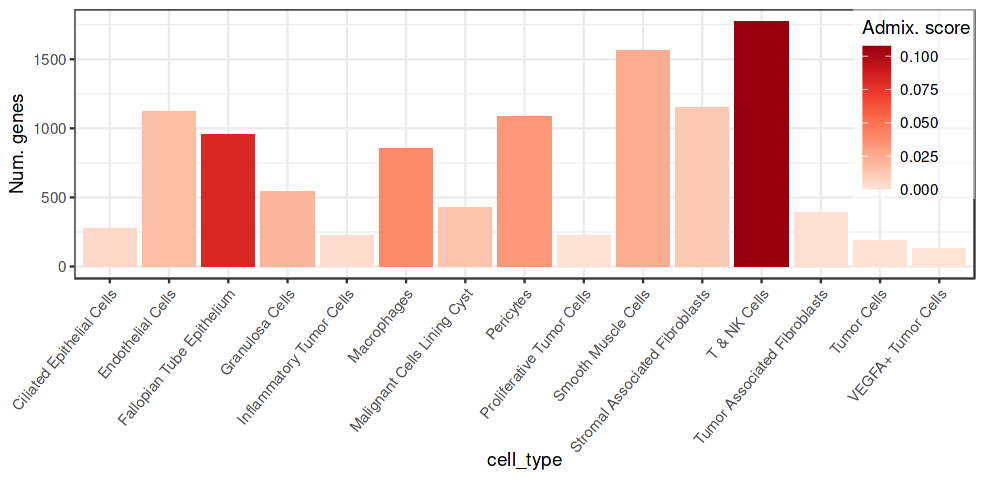

In [186]:
options(repr.plot.width=8.2, repr.plot.height=4)
gg_n_gene_dep <- ggplot(p_df) +
  geom_col(aes(x=cell_type, y=n_genes, fill=score)) +
  ylab('Num. genes') +
  scale_fill_distiller(palette='Reds', name='Admix. score', limits=c(0, NA), direction=1) +
  theme(axis.text.x=element_text(angle=50, vjust=1, hjust=1)) +
  theme_legend(position=c(1, 1))

gg_n_gene_dep

## Downsample cells

In [20]:
subsample_count_matrix <- function(mat, prob=0.5) {
    mat@x %<>% rbinom(n=length(.), size=., prob=prob) %>% as.numeric()
    return(drop0(mat))
}

In [21]:
prob_vec <- seq(0.1, 0.5, by=0.1)
cms_subs <- sapply(prob_vec, \(p) subsample_count_matrix(so_spatial[['RNA']]$counts, prob=p))

In [22]:
cont_scores <- lapply(cms_subs, \(cm.spat) {
    estimate_contamination_scores(
        so_rna[['RNA']]$counts, cm.spat,
        annot.rna=so_rna$cell_type, annot.spat=so_spatial$cell_type,
        cell.type.adj.mat=cell_type_adj_mat,
        p.c=0.25, signal.thres=signal_thres, min.expr.frac=0.05,
        exclude.genes=exclude_genes
    )
})

In [23]:
doublet_dfs_subs <- mapply(\(s, p) {
    s$doublet.scores %>% tibble(scores=., cell_type=so_spatial$cell_type[names(.)], cell=names(.), subsample=p)
}, cont_scores, prob_vec, SIMPLIFY=FALSE)

Warning message:
“Removed 7076 rows containing non-finite outside the scale range (`stat_boxplot()`).”


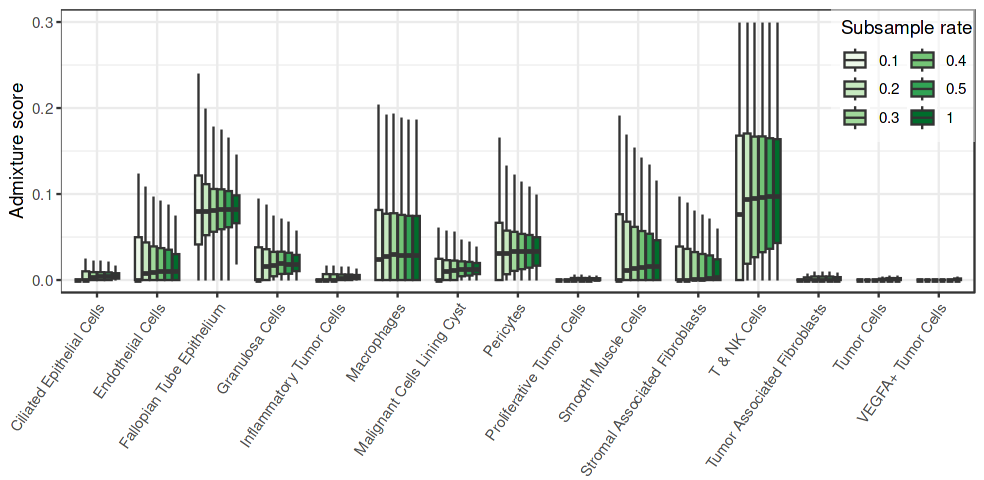

In [192]:
options(repr.plot.width=8.2, repr.plot.height=4)

p_df <- doublet_df %>%
    select(-dataset) %>% mutate(subsample=1.0) %>% rbind(bind_rows(doublet_dfs_subs))

gg_subsample <- ggplot(mutate(p_df, subsample=as.factor(subsample))) +
  geom_boxplot(aes(x=cell_type, y=scores, fill=subsample), outliers=FALSE) +
  ylim(0.0, 0.3) +
  scale_fill_brewer(palette='Greens') +
  labs(y='Admixture score', fill='Subsample rate') +
  guides(fill=guide_legend(ncol=2)) +
  theme_legend(position=c(1, 1)) +
  theme(axis.text.x=element_text(angle=55, vjust=1, hjust=1)) +
  theme(axis.title.x=element_blank())

gg_subsample

## Estimate gene scores depending on $p_c$

In [26]:
cont_frac_dependency <- function(gene.cont.probs, mask=NULL, cm, label) {
  n.genes <- if(is.null(mask)) {nrow(gene.cont.probs)} else {sum(mask)}

  cont.fracs <- apply(gene.cont.probs, 2, \(pc) {
    cellAdmix:::estimate_cell_admixture_fractions(pc, cm, mask)
  })

  colMedians(cont.fracs) %>%
    {data.frame(cell_cont=., pc=as.numeric(names(.)), label=label, n_genes=n.genes)}
}

In [76]:
pc_vals <- seq(0.05, 1.0, 0.05) %>% setNames(., .)

suppressWarnings({
  gene_cont_probs_all <- lapply(pc_vals, \(pc) {
    estimate_contamination_scores_seurat(
      so_rna, so_spatial, cell.type.adj.mat=cell_type_adj_mat,
      exclude.genes=exclude_genes,
      p.c=pc, signal.thres=0.0, min.expr.frac=0.0,
    )$cont.probs
  })
})

In [89]:
# ct <- 'T & NK Cells'
ct <- 'Macrophages'
cm_ct <- so_spatial[['RNA']]$counts[, so_spatial$cell_type == ct]

gene_cont_probs <- sapply(gene_cont_probs_all, \(x) x[, ct])
gene_cont_probs %<>% .[setdiff(rownames(.), exclude_genes),]
cm_ct <- cm_ct[rownames(gene_cont_probs),]

In [100]:
p_l <- list(
  cont_frac_dependency(gene_cont_probs, cm=cm_ct, label='0.0')
)

p_l2 <- c(0.1, 0.25, 0.4, 0.5, 0.75) %>% setNames(., .) %>% lapply(\(x) {
  gene_cont_probs %>% {cont_frac_dependency(
    ., .[,'0.25'] > as.numeric(x), cm=cm_ct,
    # label=paste0('Cont. prob. >', x)
    label=paste0(x)
  )}
})

Warning message:
“Removed 60 rows containing missing values or values outside the scale range (`geom_line()`).”


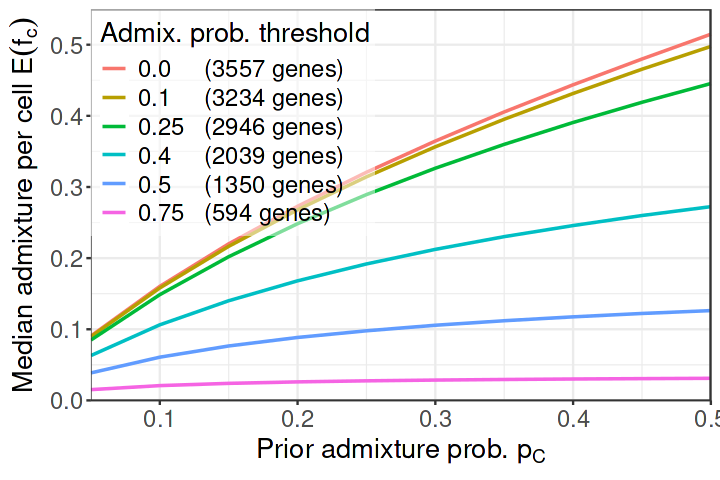

In [101]:
options(repr.plot.width=6, repr.plot.height=4)

p_df <- c(p_l, p_l2) %>% do.call(rbind, .) %>%
  mutate(label=paste0(label, strrep(' ', ifelse(nchar(label) == 4, 3, 5)), '(', n_genes, ' genes)')) %>%
  mutate(label=factor(label, levels=unique(label)))

gg_prior_dep <- ggplot(p_df) +
  geom_line(aes(x=pc, y=cell_cont, color=label), linewidth=0.75) +
  theme_legend(position=c(0, 1)) +
  scale_x_continuous(limits=c(0.05, 0.5), expand=c(0, 0)) +
  scale_y_continuous(limits=c(0, 0.55), expand=c(0, 0)) +
  guides(color=guide_legend(title='Admix. prob. threshold')) +
  theme(
    legend.title=element_text(size=16),
    legend.text=element_text(size=14, lineheight=1.5),
    axis.text=element_text(size=14), axis.title=element_text(size=16)
  ) +
  labs(x=TeX('Prior admixture prob. $p_C$'), y=TeX('Median admixture per cell $E(f_c)$'))

gg_prior_dep

## Simulations

In [31]:
library(reshape2)

In [32]:
p_cg <- function(p_ratio, pc) {
  1 / (1 + p_ratio * (1 / pc - 1))
}

theme_text <- theme(
  axis.text=element_text(size=14), axis.title=element_text(size=16),
  legend.text=element_text(size=14), legend.title=element_text(size=16)
)

Prior dependency:

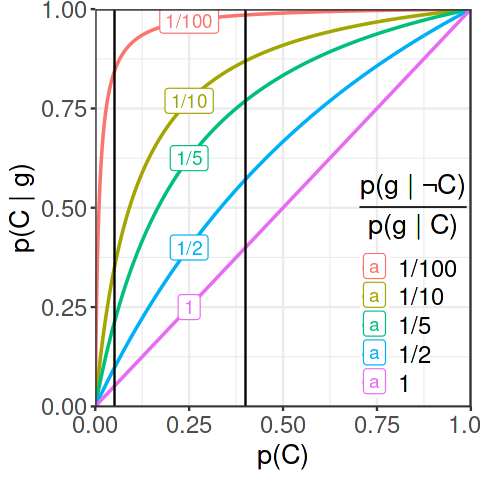

In [33]:
options(repr.plot.width = 4, repr.plot.height = 4)

p_ratios <- c('1/100', '1/10', '1/5', '1/2', '1') %>%
  sapply(\(r) eval(parse(text=r)))
pcs <- seq(0.00, 1.0, length.out = 1001)

p_df <- sapply(p_ratios, \(r) p_cg(r, pcs)) %>% data.frame() %>% set_colnames(names(p_ratios))
p_df$pc <- pcs

p_df <- melt(p_df, id.vars = "pc", variable.name = "p_ratio", value.name = "pcg")
gg_sim_ratio <- ggplot(p_df, aes(x = pc, y = pcg, color = p_ratio)) +
  geom_line(linewidth=0.75) +
  geom_vline(xintercept=c(0.05, 0.4)) +
  geom_label(data=p_df[abs(p_df$pc - 0.25) < 1e-5,], aes(x=pc, y=pcg, label=p_ratio)) +
  labs(x = "p(C)", y = "p(C | g)") +
  scale_x_continuous(expand=c(0, 0)) +
  scale_y_continuous(expand=c(0, 0)) +
  scale_color_discrete(name=TeX('\\frac{p(g | ¬C)}{p(g | C)}')) +
  theme_legend(position=c(1, 0)) +
  theme(legend.background=element_blank()) +
  theme_text

gg_sim_ratio

Example expression:

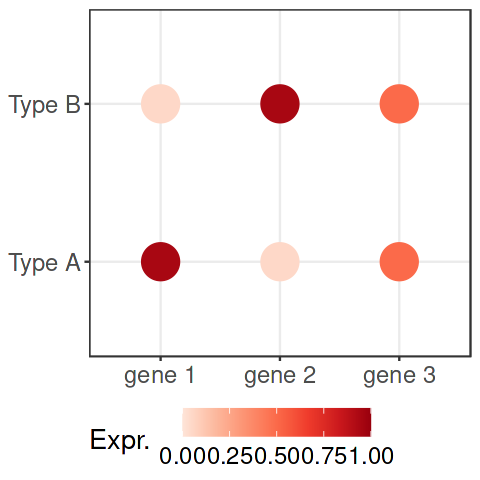

In [34]:
options(repr.plot.width = 4, repr.plot.height = 4)

p_df <- tibble(
    `Type A`=c(0.95, 0.05, 0.5),
    `Type B`=c(0.05, 0.95, 0.5),
    gene=c('gene 1', 'gene 2', 'gene 3')
  ) %>%
  mutate(gene=factor(gene, levels=gene)) %>%
  melt(id.vars = 'gene', variable.name = 'type', value.name = 'expr')

gg_sim_expr <- ggplot(p_df) +
  geom_point(aes(x=gene, y=type, color=expr), size=10) +
  scale_color_distiller(palette='Reds', direction=1, limits=c(0, 1), name='Expr.') +
  theme(axis.title.y=element_blank(), axis.title.x=element_blank()) +
  theme(
    legend.position='bottom', legend.margin=margin(), legend.key.width=unit(0.8, 'cm'),
    legend.title.position='left', legend.justification='left',
    legend.title=element_text(margin=margin(r=20))
  ) +
  theme_text

gg_sim_expr

## Compile the figure

In [158]:
plt_theme <- theme(
  axis.text=element_text(size=12), axis.title=element_text(size=14),
  legend.text=element_text(size=10), legend.title=element_text(size=12),
)

disable_x_grid <- theme(panel.grid.minor.x=element_blank(), panel.grid.major.x=element_blank())
disable_x_text <- theme(axis.text.x=element_blank(), axis.title.x=element_blank())

label_par <- list(fontface='plain', size=18)
plt_scale <- 0.95

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_bar()`).”
Warning message:
“Removed 60 rows containing missing values or values outside the scale range (`geom_line()`).”


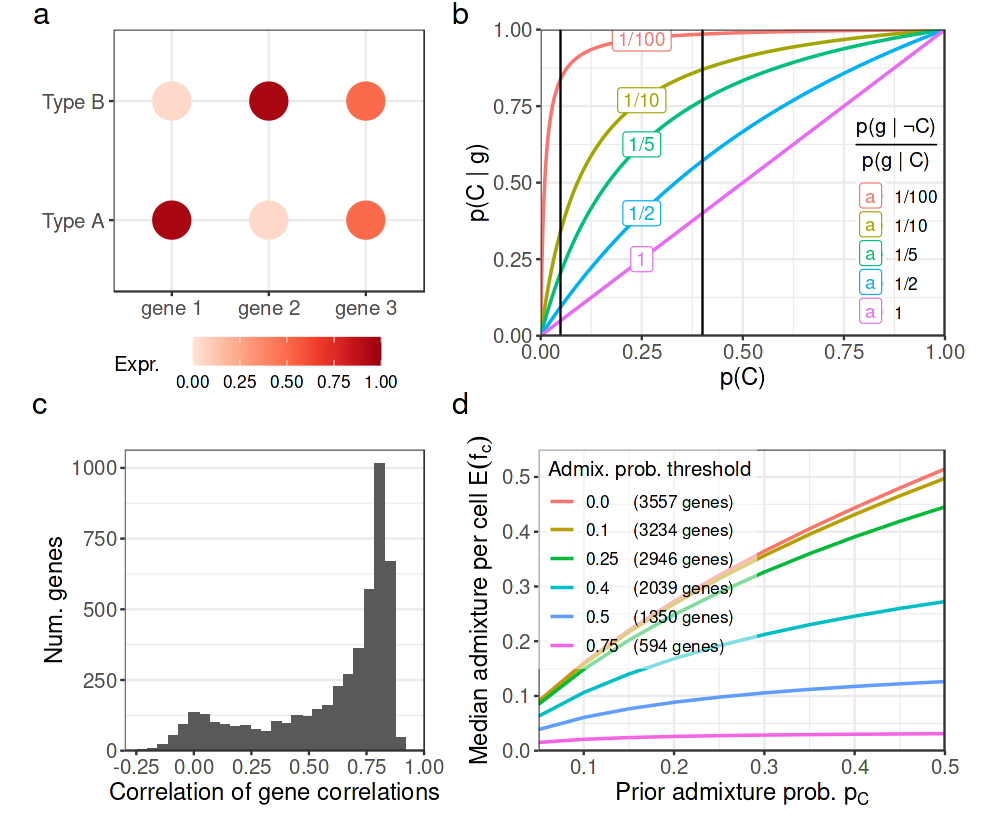

In [102]:
options(repr.plot.width=8.268, repr.plot.height=7)
plot_grid(
  plot_grid(
    gg_sim_expr + plt_theme,
    gg_sim_ratio + plt_theme,
    nrow=1, rel_widths=c(1, 1.25), scale=plt_scale,
    labels=c('a', 'b'), label_fontface=label_par$fontface,
    label_size=label_par$size, label_y=1.05
  ),
  plot_grid(
    gg_cors +
      theme(plot.title=element_blank()) +
      disable_x_grid +
      plt_theme,
    gg_prior_dep + plt_theme,
    nrow=1, rel_widths=c(1, 1.25), align='h', scale=plt_scale,
    labels=c('c', 'd'), label_fontface=label_par$fontface,
    label_size=label_par$size, label_y=1.125
  ),
  ncol=1, scale=plt_scale
)

ggsave2(OutputPath('fig_sn1.pdf'), width=8.268, height=7)

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 7076 rows containing non-finite outside the scale range (`stat_boxplot()`).”


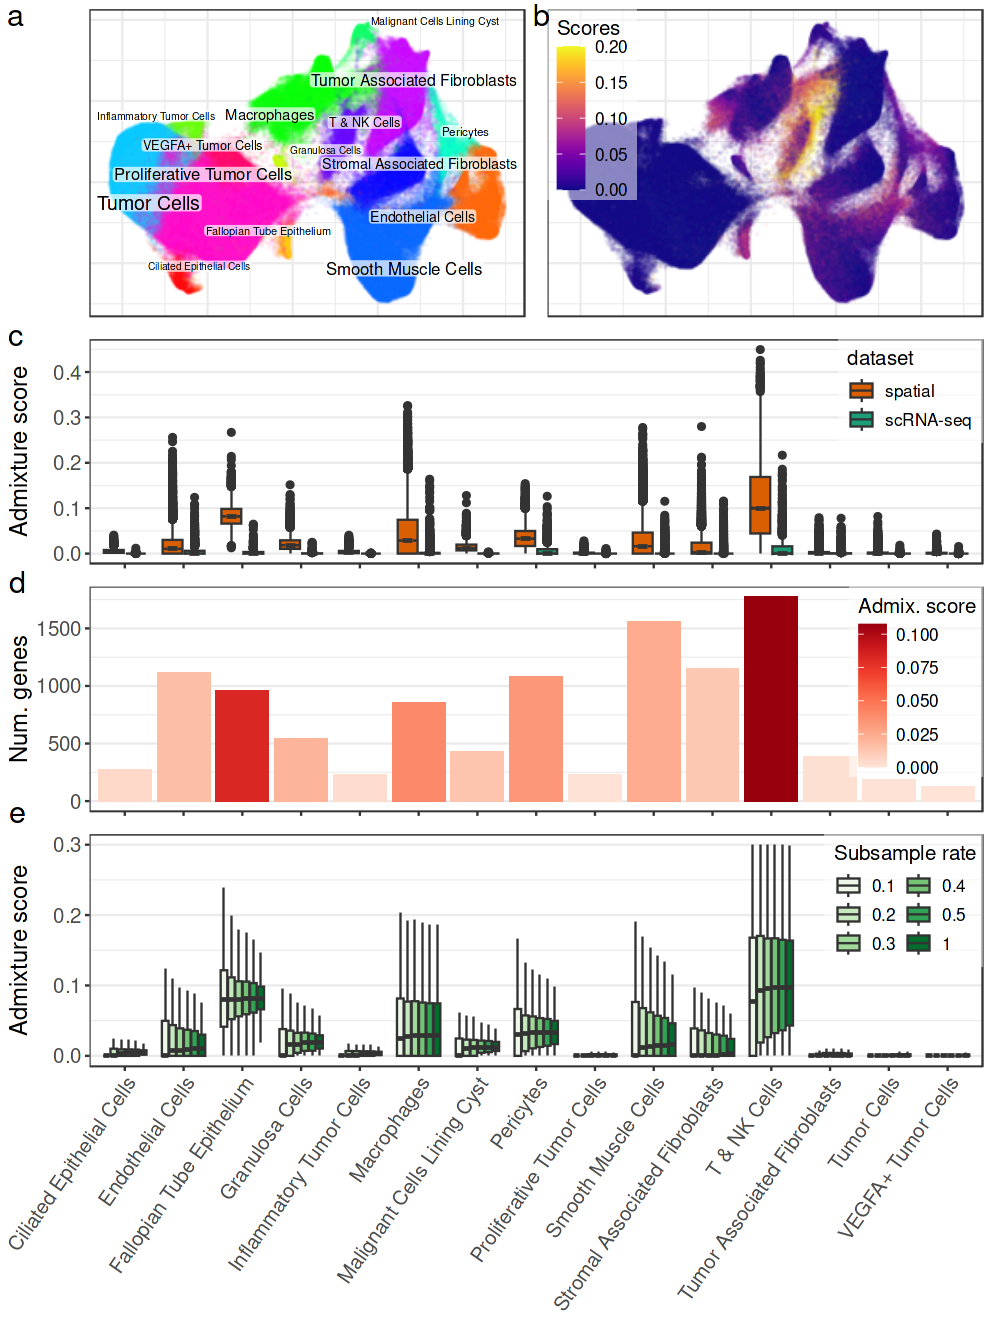

In [193]:
options(repr.plot.width=8.268, repr.plot.height=11)
suppressMessages(print(plot_grid(
  plot_grid(
    NULL,
    rasterise(gg_cell_type_umap) + plt_theme +
      theme(axis.title=element_blank(), axis.text=element_blank()),
    rasterise(gg_score_umap) + plt_theme + theme_legend(position=c(0, 1)) +
      theme(axis.title=element_blank(), axis.text=element_blank()),
    nrow=1, rel_widths=c(0.165, 1, 1),
    labels=c('a', '', 'b'), label_fontface=label_par$fontface,
    label_size=label_par$size, label_y=1.02, label_x=-0.02
  ),
  plot_grid(
    gg_scores + plt_theme + disable_x_grid + disable_x_text,
    gg_n_gene_dep + plt_theme + disable_x_grid + disable_x_text,
    gg_subsample +
      guides(fill=guide_legend(ncol=2)) +
      plt_theme + disable_x_grid + theme(axis.title.x=element_blank()),
    ncol=1, align='v', rel_heights=c(1, 1, 2),
    labels=c('c', 'd', 'e'), label_fontface=label_par$fontface,
    label_size=label_par$size, label_y=1.07
  ),
  ncol=1, rel_heights=c(1, 3)
)))

ggsave2(OutputPath('fig_sn2.pdf'), width=8.268, height=11)